# Notebook to generate the plots in the Repport

In [1]:
## imports
import torch 
from stimulus import *
from BIRNN import *
%matplotlib inline
import matplotlib.pyplot as plt 
from tqdm import trange
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from ipywidgets import interact_manual, FloatSlider
from IPython.display import display,  clear_output

current_dir_path = os.getcwd()
figure_directory_name = 'repport_figures'
figures_directory_path = os.path.join(current_dir_path, figure_directory_name)
if not os.path.exists(figures_directory_path):
    os.mkdir(figures_directory_path)

### Code to generate 2 signal and expected output examples. One positive, one negative

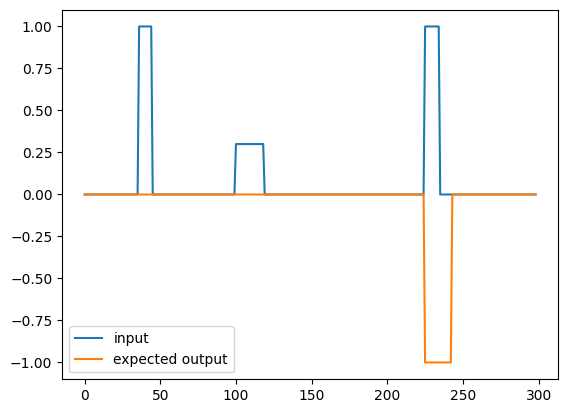

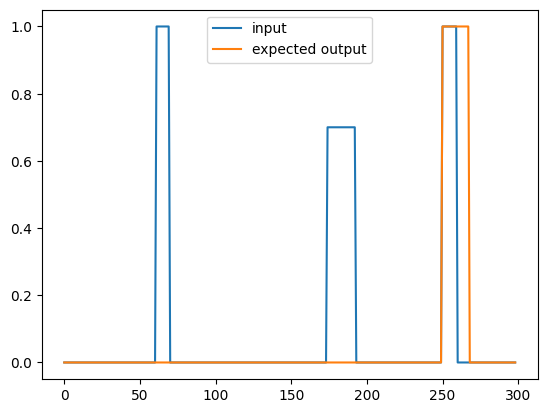

In [2]:
stimG = StimGenerator(dt=.1)
d_i, d_o = stimG.get_batch_data(1,random=False,stim_type=True)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
# d_i, d_o = stimG.concat_sim(d_i, d_o)

fig_signal1 =plt.figure()
ax = fig_signal1.add_subplot()
ax.plot(d_i[0], label = 'input')
ax.plot(d_o[0], label = 'expected output')
ax.legend()
#fig_signal1.show()
fig_signal1.savefig(figures_directory_path + '/signal1.pdf')

fig_signal2 =plt.figure()
d_i, d_o = stimG.get_batch_data(1,random=False,stim_type=False)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
ax = fig_signal2.add_subplot()
ax.plot(d_i[0], label = 'input')
ax.plot(d_o[0], label = 'expected output')
ax.legend()
#fig_signal2.show()
fig_signal2.savefig(figures_directory_path + '/signal2.pdf')


## Biffurcation diagram for BRC

In [3]:
def pulse(t, begin , end):    
    return  np.heaviside(t - begin, 0) - np.heaviside(t - end, 0)

def make_BRC_trajectory_plots():
    fig, ax = plt.subplots()

    hfs = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100), indexing='ij')
    hfs = np.concatenate((np.expand_dims(hfs[0], 0), np.expand_dims(hfs[1], 0)))

    t_steps = np.arange(500)
    a_t = np.linspace(0,2,500)
    x_t = 0.1 * np.sin(t_steps/10)

    trajectory = [0.0]

    def get_ode(pars):
        _, c, x = pars['a'], pars['c'], pars['x']

        def f(a, hf):
            return c * hf + (1 - c) * np.tanh(x + a * hf)

        return f

    def animate(frame_num):
        ax.clear()
        pars = {'a': a_t[frame_num],
                'c': 0.3,
                'x': x_t[frame_num]}

        func = get_ode(pars)
        ax.contourf(hfs[0], hfs[1], func(hfs[0], hfs[1]) - hfs[1], 0)
        trajectory.append(func(a_t[frame_num], trajectory[-1]))
        ax.set_title("Time_step: " + str(frame_num) + ' Input = ' + str(x_t[frame_num]))
        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(-2, 2)
        ax.set_xlabel("a")
        ax.set_ylabel("cell output")
        ax.plot(a_t[:frame_num], trajectory[:frame_num], 'r')
        ax.plot(a_t[frame_num], trajectory[frame_num], 'ro')

    anim = FuncAnimation(fig, animate, frames=499, interval=100, repeat=True, repeat_delay=500)
    anim.save(figures_directory_path + "/BRC_trajectory.gif", writer='pillow')
    
    pars = {'a': 1,
            'c': 0.3,
            'x': 0}

    func = get_ode(pars)
    ax.clear()
    ax.contourf(hfs[0], hfs[1], func(hfs[0], hfs[1]) - hfs[1], 0)

    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-2, 2)
    ax.set_xlabel("a")
    ax.set_ylabel("cell output")
    ax.plot(a_t[:500], trajectory[:500], 'r')
    ax.plot(a_t[-1], trajectory[-1], 'ro')
    fig.savefig(figures_directory_path + "/BRC_trajectory.pdf",)

#make_BRC_trajectory_plots()

## Draw 3 charachteristic BEF trajectories and phase planes

##### Function to generate the trajectory from random paramaeters

Button(description='Randomize Parameters', style=ButtonStyle())

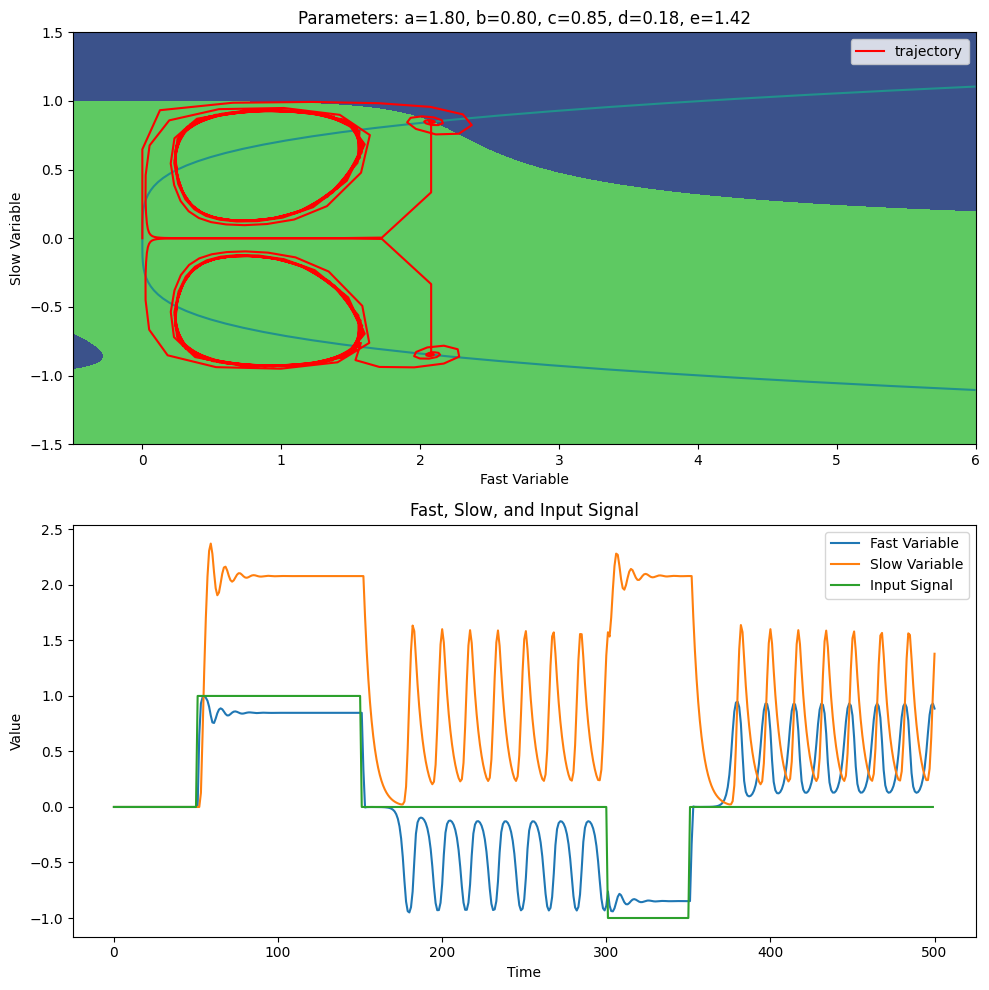

In [4]:
def update_BEF_plots_random(button):
    def BEF_transition(hf, hs, pars,input = 0):
        # size (B, V)
        a,b,c,d,e = pars['a'],pars['b'],pars['c'],pars['d'],pars['e']
        hfn = hf * (1-c) + c*torch.tanh(input  + (a + b*hf**2 - hs)*hf) #0 input response
        hsn = hs*(1-d) + d*(e*hf)**4
        return hfn, hsn 

    clear_output(wait=True)
    
    a = np.random.uniform(0, 2)
    b = np.random.uniform(0, 3)
    c = np.random.uniform(0.3, 1)
    d = np.random.uniform(0.03, 0.3)
    e = np.random.uniform(0, 2)
    
    pars = {'a': a, 'b': b, 'c': c, 'd': d, 'e': e}
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    
    ### parameters to generate a trajectory
    trajectory_times_steps = 500
    trajectory = [[torch.tensor(0),torch.tensor(0)]]        
    input_amplitude = 1
    input_signal = input_amplitude * pulse(np.arange(trajectory_times_steps),50,150)
    input_signal = input_signal  - pulse(np.arange(trajectory_times_steps),300,350)

    
    # Phase portrait and trajectory plot
    hfs = torch.meshgrid(torch.linspace(-1.5,1.5, 100), torch.linspace(-.5,6,100), indexing = 'ij')
    hfs = torch.cat((hfs[0].unsqueeze(0), hfs[1].unsqueeze(0)))
    hfn, hsn = BEF_transition(hfs[0], hfs[1], pars, input_amplitude)
    axs[0].contourf(hfs[1], hfs[0], hfn - hfs[0], 0)
    axs[0].contour(hfs[1], hfs[0], hsn - hfs[1], 0)
    axs[0].set_title(f'Parameters: a={a:.2f}, b={b:.2f}, c={c:.2f}, d={d:.2f}, e={e:.2f}')
    axs[0].set_xlabel('Fast Variable')
    axs[0].set_ylabel('Slow Variable')
    
    ## generate the trajectory
    for i in range(trajectory_times_steps):
        next_fast, next_slow = BEF_transition(trajectory[-1][0], trajectory[-1][1], pars, input=input_signal[i])
        trajectory.append([next_fast, next_slow])
    trajectory = np.array(trajectory)
    axs[0].plot(trajectory[:, 1], trajectory[:, 0], label="trajectory", color="r")
    axs[0].legend()
    
    # Fast, slow, and input signal plot
    axs[1].plot(trajectory[:, 0], label="Fast Variable")
    axs[1].plot(trajectory[:, 1], label="Slow Variable")
    axs[1].plot(input_signal, label="Input Signal")
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Value')
    axs[1].set_title('Fast, Slow, and Input Signal')
    axs[1].legend()
    
    plt.tight_layout()
    display(button)
    plt.show()
    

button = widgets.Button(description='Randomize Parameters')
button.on_click(update_BEF_plots_random)
display(button)

### Spiking trajectory